<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

# Uncertainty in Ensemble Learners

#### Zhikai (Ben) Zhong, Undergraduate Student, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/benzhong)

#### Supervised by:

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### For PGE 376

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)




## Loading the required libraries
The following code loads the required libraries.

In [13]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn import metrics                                 # measures to check our models
from sklearn.tree import export_graphviz                    # graphical visualization of trees
from sklearn.preprocessing import StandardScaler            # standardize variables to mean of 0.0 and variance of 1.0

from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor          # random forest method
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information

import random

import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call

from pylab import *
from scipy.stats import norm

from tqdm.notebook import tqdm
import time

import numpy as np
import scipy.stats
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

## Defining Functions
There are two functions: 
1. **create_df (model, X_test, y_test)**


2. **plot_df (df, dx)**

The **create_df** function creates a pandas dataframe where each row represents a testing sample, first columns is the true value of the testing sample, and every column after represents the prediction of each estimators in a ensemble learner.

The **plot_df** function takes in the aforementioned dataframe and returns an accuracy plot. 


In [93]:
test_size=[.1,.2,.3,.4,.5,.6,.7,.8,.9]

class Uncertainty_Modeling(object):
    
    def __init__(self,filename):
        #The dataset is composed of porosity, brittleness, permeability and other positive variables. 
        #Therefore we assume all the negative values to be 0 due to inaccuracy in measurements. 
        my_data = pd.read_csv(str(filename)) 
        num = my_data._get_numeric_data() # get the numerical values
        num[num < 0] = 0  #filtering out unrealistic values that are less than 0
        self.dataset=num
        feature_cols = ['Por',
                        'Brittle',
                        'LogPerm',
                        'AI',
                        'TOC',
                        'VR'
                       ]
        #We split the data into training and testing data for the purpose of cross validation.
        #We use the command train_test_split from sklearn. 
        #We set the **random_state** variable to 0 (or any other integer) to make sure our results are reproducible. 
        X=self.dataset[feature_cols]
        y=self.dataset.Production
        #50% Testing 50% Training
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.5, random_state=0) 
        
    def split_data(self,test_size=.5,validate=True):
        
        feature_cols = ['Por',
                        'Brittle',
                        'LogPerm',
                        'AI',
                        'TOC',
                        'VR'
                       ]
        #We split the data into training and testing data for the purpose of cross validation.
        #We use the command train_test_split from sklearn. 
        #We set the **random_state** variable to 0 (or any other integer) to make sure our results are reproducible. 
        X=self.dataset[feature_cols]
        y=self.dataset.Production
        #50% Testing 50% Training
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=0) 
        #from training dataset, randomly select 4 rows as validation data
        #1000*.5*.008=4
        if validate==True:
            self.X_train, self.X_val, self.y_train, self.y_val  = train_test_split(self.X_train, self.y_train, test_size=4/len(y)/test_size, random_state=1) # 0.25 x 0.8 = 0.2

    def build_RF(self, 
                 n_estimators=300, 
                 random_state=42,
                 min_samples_leaf=None, 
                 max_features=None, 
                 max_depth=None,
                max_leaf_nodes=None):
        
        model=RandomForestRegressor(n_estimators=n_estimators, 
                                    random_state=random_state, 
                                    max_depth=max_depth,
                                   max_leaf_nodes=max_leaf_nodes,
                                   max_features=max_features)
        self.model=model.fit(self.X_train,self.y_train)
        
    def calc_accuracy(self):
        
        self.accuracy=round(explained_variance_score(self.y_test, self.model.predict(self.X_test)),3)
        
        return self.accuracy
        
#a function that creates a dataframe where each column contains an estimator's prediction
#with the first column being the true value
#and each row corresponds to each sample in the testing set
    def create_df(self,validate=False):           
        
        y=self.y_test
        X=self.X_test
        if validate==True:
            y=self.y_val
            X=self.X_val
        df=pd.DataFrame(y)                                 #creating the dataframe with true value in it
        df.columns.values[0] = "True_Value"
        df=df.reset_index(drop=True)
        count=0
        for i in self.model.estimators_:                             #looping over the model's individual estimators(trees)  
            count+=1
            Df=pd.DataFrame(i.predict(X))
            Df.columns=['L='+str(count)]    
            df=pd.concat([df, Df], axis=1)   #add each prediction to a new column 
        
        self.df=df

#a function that takes in the aforementioned dataframe
    def calc_percentage(self,dx):
        
        m,n=self.df.shape
        percentile=np.arange(0,1,dx)
        percentage=[]
        for i in range(0,m):                                    #looping over each row        
            find=False; count=0
            True_value=self.df.iloc[i,0]
            row=self.df.iloc[i,1:]
            while find==False and count<len(percentile):
                for percent in percentile:                      #looping over each row
                    down=np.percentile(row,(1-percent)/.02); up=np.percentile(row, 100-(1-percent)/.02)
                    if True_value<=up and True_value>=down:     #finding the percentile of true value among the estimated values
                        percentage=np.append(percentage,percent)
                        find=True
                        break
                    else:
                        count+=1
        lst=[]
        for i in percentile:                                    #calculating % samples in each CI
            s=sum([1 for x in percentage if x <=i])
            lst=np.append(lst,s)
        lst/=m  
        self.percentage=lst
        
        x=np.linspace(0,1,len(lst))
        y=x
        
        #goodness measure
        a=np.array(lst-y)
        self.goodness=round(1-2*np.sum((3*np.array([1 if i>=0 else 0 for i in a])-2)*a*dx),4)
        
    def accuracy_plot(self):
        
        #the diagonal line
        x=np.linspace(0,1,len(self.percentage))
        y=x
        #plotting accuracy plot  
        textstr = '\n'.join((
            r'Goodness' % (self.goodness, ),
            r'Accuracy' % (self.calc_accuracy(), ),
            ))
    
        plt.plot(x,y,'black');
        plt.text(.5,.2,textstr,bbox={'facecolor':'grey','alpha':0.2,'pad':7})
        plt.plot(x,np.array(self.percentage),'ro')
        plt.xlabel('Probability Interval', fontsize=14); plt.ylabel('Percentage of Samples ', fontsize=14); 
        plt.title('Accuracy Plot', fontsize=20)
        fill([0,1,1,0], [0,1,1,1], 'black', alpha=0.1, edgecolor='black')
    
    def plot_hist(self,
                  ax,
                  n=0,
                  CI=.9,
                  alpha_CI=.2,
                  alpha_bins=.15,
                  bins=20):
        
        preds=self.df.iloc[n,1:]                                 # For example, let's pick the 1st testing sample to graph
        preds_true=float(self.df.iloc[n,0])
        height, bins, patches=ax.hist(preds,alpha=alpha_bins,bins=bins,color='r')
        ci = norm(*norm.fit(preds)).interval(CI)               # Confidence interval of 90%
        ax.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=alpha_CI)
        ax.axvline(preds_true, color='k', linewidth=1,label='True Value')
        #ax.set_xlabel('Production Prediction')
        #ax.set_ylabel('Frequency')
        #ax.title.set_text('Prediction Distribution')



## Preping The Data

### Loading dataset



In [86]:
Maxnodes_experiment=Uncertainty_Modeling('unconv_MV.csv')
Maxnodes_experiment.dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.000000,250.75000,500.50000,750.250000,1000.00000
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


In [87]:
#sns.pairplot(Maxnodes_experiment.dataset)

## Looking At The Model

### Building The Model

In this example, we use randomforest regressor to predict the intial gas production with several features.

We are going to create a model and then cross validate it with the testing data and give it a regression score.

The best score is 1.

In [88]:
Maxnodes_experiment.build_RF()
#Model built

In [89]:
Maxnodes_experiment.calc_accuracy()
#See the correlation between our model and the testing data
#We have a pretty good score, meaning our model does a good job predicitng gas production
#However, does our model have an accurate uncertainty model?

0.944

### Individual Estimators

Ensemble learners are consisted of many individual estimators (trees). Each individual estimators will make a prediction and we yield the final prediction from the results of those estimators predictions.

We can have each individual tree make a prediction and plot their distribution in a histogram.

Ideally, this should be a normal distribution. 

We need to be able to offer a confidence interval for our prediction.

Ideally, X% of the testing samples should fall into the confidence interval of X%.
* For instance, 95% of times, the testing sample should fall into the model's 95% confidence interval

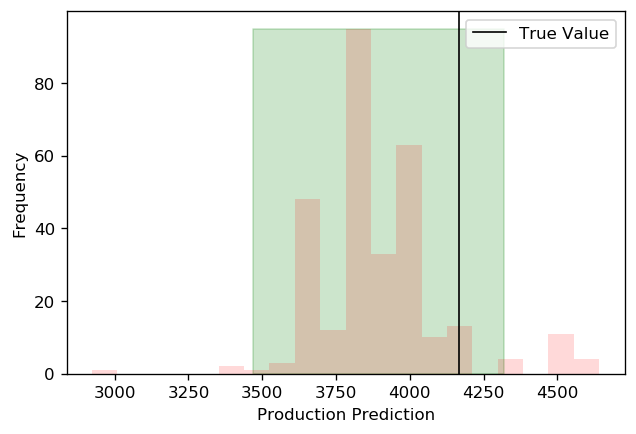

In [102]:
fig, ax=plt.subplots(figsize=(6,4),dpi=120)
Maxnodes_experiment.create_df()
Maxnodes_experiment.plot_hist(ax=ax,CI=.95)


## Uncertainty Modeling

### Plotting Accuracy Plot

Use the previously defined functions to determine whether the model is overfitting or underfitting.

We are going to plot the proportion of true data within [10,20,30,40,50,60,70,80,90]% interval. 

If the datapoints land in the shaded area, that means the model is **accurate but imprecise**.

If the datapoints land on the line, that means the model is **accurate and precise**.

If the datapoints land in the unshaded area, that means the model is **inaccurate and imprecise**.

In [ ]:
Maxnodes_experiment.calc_percentage(.02)
plt.subplots(figsize=(6,6))
Maxnodes_experiment.accuracy_plot()

### Improving The Uncertainty Model
The hypothesis is that we can improve the precision of our model by simplifying the each individual estimators of an ensembler learner. 

This could be done in many ways simply by adjusting the hyperparameters of an ensemble learner.

Here are two common hyperparameters we can adjust:

**1. min_samples_leaf**

This controls the minimum sample of a leaf/leaves. When splitting, only nodes that contains more samples than the threshold would be split into a leaf.

**2. max_depth**

This controls the maximum depth an individual estimator (tree) will grow. Nodes will stop splitting once the tree depth has grown to this value.

**3. max_leaf_nodes**

This controls the maximum leaf nodes when trees are grown. The best nodes are kept, in terms of relative reduction in impurity.
#### These hyperparametes affect the size of each estimator (tree)

#### Max Leaf Nodes

The default value is None. When it's none, all the trees are fully grown.

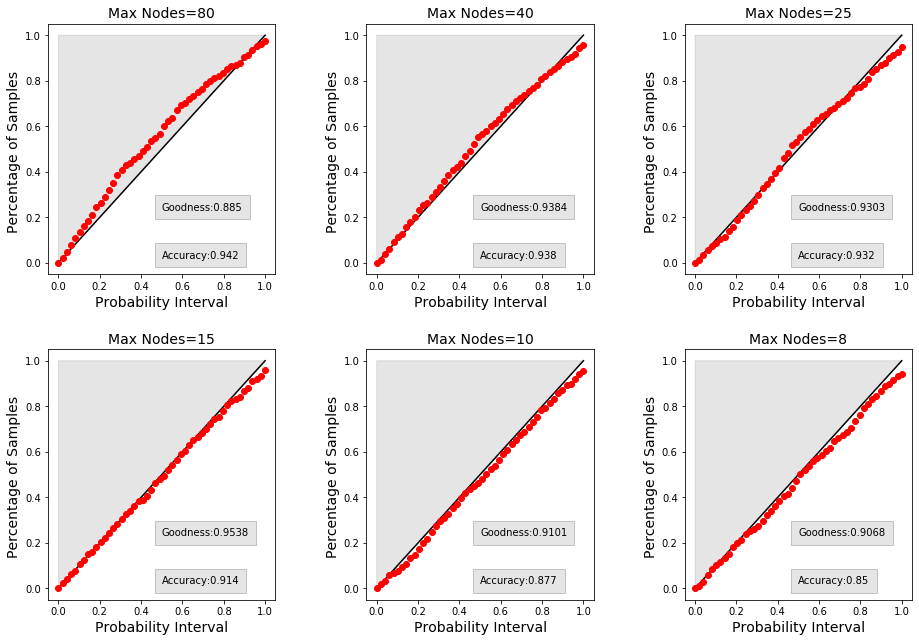

In [8]:
max_nodes=[80,40,25,15,10,8]
index=1
for i in tqdm(max_nodes):
    plt.subplot(2, 3, index)
    Maxnodes_experiment.build_RF(max_leaf_nodes=i)
    Maxnodes_experiment.create_df()
    Maxnodes_experiment.calc_percentage(.02)
    Maxnodes_experiment.accuracy_plot()
    plt.title('Max Nodes='+str(i),fontsize=14)
    index+=1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

#As you can see from the graphs below, tree complexity affects the uncertainty model
#When max_leaf_nodes is 5, the model is inaccurate and imprecise
#When max_leaf_nodes gets above 10, the model starts to underfit
#The most optimal setting would probably be 9. 

In [11]:
max_nodes = np.arange(5,100,1)
goodness = []

for i in tqdm(max_nodes):
    Maxnodes_experiment.build_RF(max_leaf_nodes=i)
    Maxnodes_experiment.create_df()
    Maxnodes_experiment.calc_percentage(.02)
    goodness=np.append(goodness, Maxnodes_experiment.goodness)


Text(0, 0.5, 'Goodness Measure')

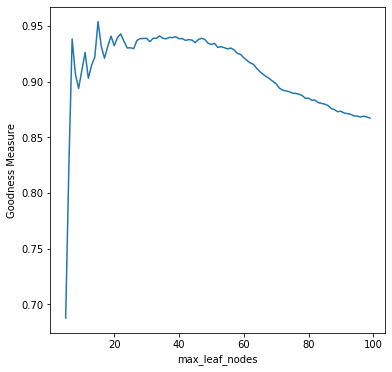

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(max_nodes,goodness,label='Goodness Measure')

ax.set_xlabel('max_leaf_nodes')
ax.set_ylabel('Goodness Measure')

A precise model is built here with adjusted hyperparameters. The model is validated with 4 rows of validation data. 

In [103]:
Precise=Uncertainty_Modeling('unconv_MV.csv')
Precise.split_data()
Precise.build_RF(max_leaf_nodes=18)

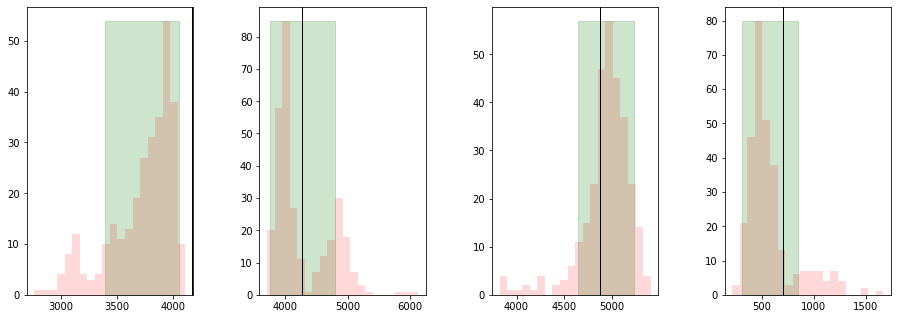

In [108]:
fig, axes=plt.subplots(1,4)
axes.flatten()
for i in range(4):
    Precise.create_df()
    Precise.plot_hist(ax=axes[i],n=i, CI=.75)
fig.tight_layout()
fig.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)

### Conclusion

**Size of the trees affects uncertainty modeling whereas restraining splitting criterias does not seem to help with uncertainty modeling**